In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'ibm' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 5 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'aapl':'12/12/1980' # Updated 1/2/21 1D, 5D ahead
               , 'acy': '01/18/1998' # Updated 1/2/21 1D, 5D ahead
               , 'amd': '03/17/1980' # Updated 1/2/21 1D, 5D ahead
               , 'baba': '09/15/2014' # Updated 1/2/21 1D, 5D ahead
               , 'bac': '02/19/1973' # Updated 1/2/21 1D, 5D ahead
               , 'crm': '06/23/2004' # Updated 1/2/21 1D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 1/2/21 1D, 5D ahead
               , 'goog': '08/16/2004' # Updated 1/2/21 1D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 1/2/21 1D, 5D ahead
               , 'idex': '05/23/2007' # Updated 1/1/21
               , 'intc': '03/16/1980' # Updated 1/1/21
               , 'iyw': '05/15/2000' # Updated 1/1/21
               , 'ma': '05/21/2006' # Updated 1/1/21
               , 'msft': '03/10/1986' # Updated 1/1/21
               , 'nio': '09/10/2018' # Updated 1/1/21
               , 'nvda': '01/22/1999' # Updated 1/1/21
               , 'pypl': '07/05/2015' # Updated 1/1/21
               , 'tsla': '06/29/2010' # Updated 1/1/21
               , 'v': '03/16/2008' # Updated 1/1/21
               , 'vbiv': '09/04/2002' # Updated 1/1/21
               , 'vgt': '01/26/2004' # Updated 1/1/21
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-17,126.089996,124.910004,126.080002,125.550003,3788000.0,125.550003,0.004204,0.009447,0.000000,0.010579,0.000987,1
2020-12-18,126.400002,124.970001,125.589996,125.849998,7552800.0,125.849998,-0.002070,0.011443,0.002389,0.009934,0.002569,-1
2020-12-21,124.180000,121.720001,123.970001,123.389999,6115700.0,123.389999,0.004679,0.020210,-0.019547,0.013913,-0.000149,1
2020-12-22,124.220001,122.410004,123.309998,123.610001,4336100.0,123.610001,-0.002433,0.014786,0.001783,0.009116,-0.003678,1
2020-12-23,125.209999,123.739998,123.879997,123.900002,2693900.0,123.900002,-0.000161,0.011880,0.002346,0.009520,-0.002606,1
2020-12-24,125.099998,124.209999,125.000000,124.690002,1761100.0,124.690002,0.002480,0.007165,0.006376,0.010348,-0.001330,-1
2020-12-28,126.599998,124.459999,125.099998,124.820000,3615200.0,124.820000,0.002238,0.017194,0.001043,0.010243,-0.001600,-1
2020-12-29,125.480003,123.239998,125.349998,123.800003,3487000.0,123.800003,0.012365,0.018176,-0.008172,0.005360,0.000675,-1
2020-12-30,124.849998,123.629997,123.800003,124.339996,3380300.0,124.339996,-0.004362,0.009868,0.004362,0.005612,0.001191,-1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.72277754 0.72277754 0.72277754]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

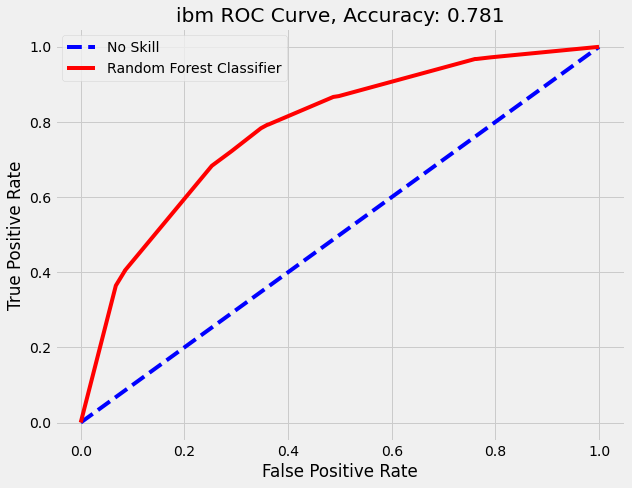

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

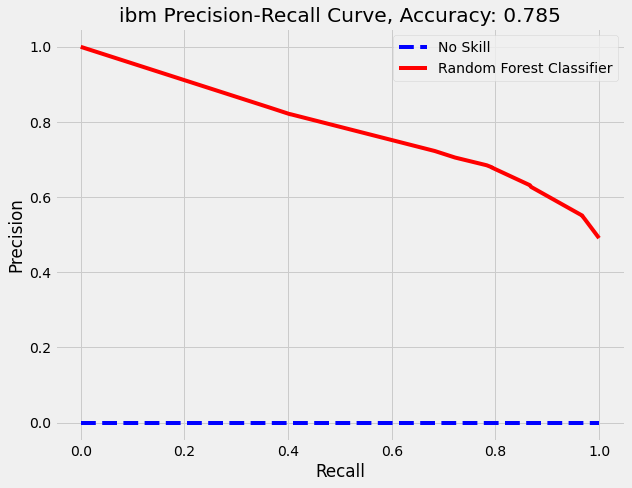

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

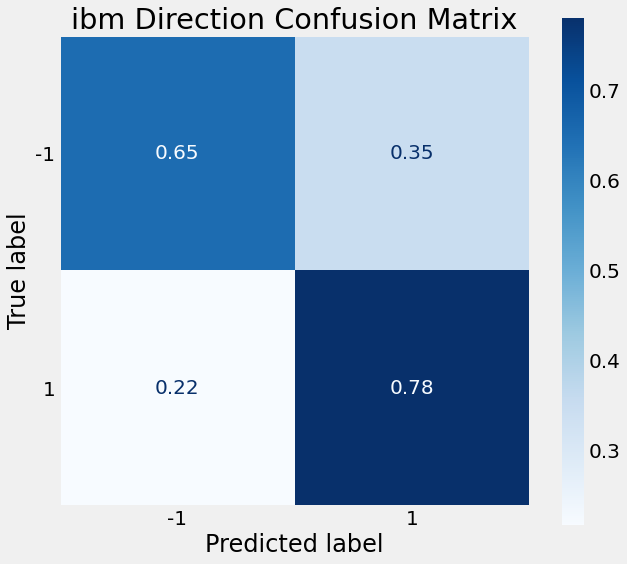

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.728042409046114'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          1.260300e+02
Low           1.239900e+02
Open          1.242200e+02
Close         1.258800e+02
Volume        3.574400e+06
Adj Close     1.258800e+02
oc           -1.336336e-02
hl            1.645295e-02
adj           1.238540e-02
5stdev_adj    7.579251e-03
5sma_adj      3.198832e-03
direction    -1.000000e+00
Name: 2020-12-31 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.013363
hl            0.016453
5stdev_adj    0.007579
5sma_adj      0.003199
Name: 2020-12-31 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    14848.000000
mean         0.000414
std          0.015950
min         -0.235185
25%         -0.007734
50%          0.000000
75%          0.008220
max          0.131637
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Sell or hold ibm


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-24,125.099998,124.209999,125.000000,124.690002,1761100.0,124.690002,0.002480,0.007165,0.006376,0.010348,-0.001330,-1,1,0.001043
2020-12-28,126.599998,124.459999,125.099998,124.820000,3615200.0,124.820000,0.002238,0.017194,0.001043,0.010243,-0.001600,-1,1,-0.008172
2020-12-29,125.480003,123.239998,125.349998,123.800003,3487000.0,123.800003,0.012365,0.018176,-0.008172,0.005360,0.000675,-1,1,0.004362
2020-12-30,124.849998,123.629997,123.800003,124.339996,3380300.0,124.339996,-0.004362,0.009868,0.004362,0.005612,0.001191,-1,-1,-0.012385
2020-12-31,126.029999,123.989998,124.220001,125.879997,3574400.0,125.879997,-0.013363,0.016453,0.012385,0.007579,0.003199,-1,-1,-0.000000


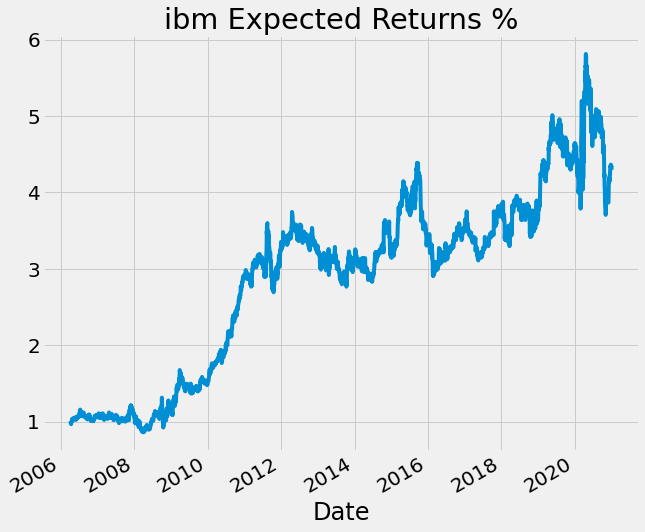

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

3.7275258700305707

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

6.6799998324296945

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/